In [1]:
# import library for reading data
import pandas as pd
import numpy as np

# import library for visualization
import seaborn as sns

# import library for preprocessing data
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# import library for making pipelines
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# import library for sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# import library for time comparision
import time

### Read Data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
df.shape

(595212, 59)

The goal of this notebook is to show examples about how I handle imbalanced classification problems. The data source is from Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies. The problem is to predict if a driver will initiate an auto insurance claim. Here is a link for this data source: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

### Problem Exploration

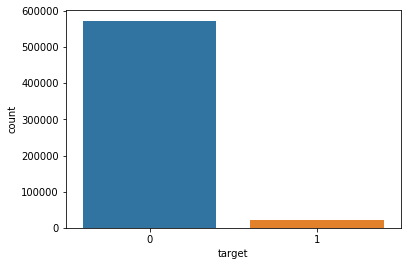

In [5]:
# visualization imbalance
sns.countplot(x = 'target', data = df)

In [6]:
y = [0, 1]
counts = df['target'].value_counts()
pct = round(df['target'].value_counts() / df['target'].value_counts().sum() * 100, 3)
table = zip(y, counts, pct)
table = pd.DataFrame(table, columns = ['target', 'counts', 'pct'])
table

,target,counts,pct
0,0,573518,96.355
1,1,21694,3.645


In [8]:
# regular pipeline
def regular_pipeline():
    # read data
    df = pd.read_csv('train.csv')
    
    # split data
    y = df['target']
    X = df.drop(columns = ['target'])
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    # preprocess data
    num_cols = X.columns[X.dtypes == 'float64']

    ## handle numerical variable: input median, standard scaler in linear method
    num_proc_nlin = make_pipeline(SimpleImputer(missing_values = -1, strategy = 'median'))

    processor_nlin = make_column_transformer(
        (num_proc_nlin, num_cols),
        remainder = 'passthrough')
    
    # run CV with classifier
    pipe = make_pipeline(processor_nlin, RandomForestClassifier())
    start = time.time()
    scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring = ['accuracy', 'recall', 'f1'])
    stop = time.time()
    print ('accuracy: ' + str(round(scores['test_accuracy'].mean(), 3)))
    print ('recall: ' + str(round(scores['test_recall'].mean(), 3)))
    print ('f1: ' + str(round(scores['test_f1'].mean(), 3)))
    print (f"CV time: {round(stop - start, 3)}s")
    
regular_pipeline()

accuracy: 0.963
recall: 0.0
f1: 0.0
CV time: 805.219s


Train data with more than 590k of record is severely imbalanced, where more than 96% of driver do not claim an auto insurance. As shown above, a CV is run on 80% data with a usual classification pipeline. A RandomForestClassifier is used here since categorical variables are label-encoded, a non-linear method makes more sense without further encoding. Again this notebook does not focus on data preprocessing, but showing an example to handle imbalanced data.

A model with 96% accuracy may delight people, but I never want to see a classification model with 0% recall. This number implies that our model treats minority class as noise during training, which does not make sense. The reason why we need to model this insurance data is to find out bad drivers, raise the cost of insurance for bad drivers and reduce the price for good ones. If we treat minority class as noise, we are asking good drivers to pay as much as bad drivers with the assumption that good drivers are much less likely to claim insurance.

### Solutions
The first problem to address is sampling. I make sure to use stratified sampling when I sample data especially in CV to make sure that each fold has samples for minority class.

The second thing I would like to do is to put more weights on minority class while training. There are 3 ways to do so.
1. Oversampling samples with the minority class
2. Undersampling samples with the majority class
3. Hyperparameter Tuning

Here is a regular pipeline with a sampler. Due to data size, using an oversampler will cost too much time to run a CV. Hence in the following section, examples of an undersampler and xgboost hyperparameter are provided without an oversampler example.

In [5]:
def pipeline_with_sampler(sampler, classifier):
    # read data
    df = pd.read_csv('train.csv')
    
    # split data
    y = df['target']
    X = df.drop(columns = ['target'])
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
    
    # preprocess data
    num_cols = X.columns[X.dtypes == 'float64']

    ## handle numerical variable: input median, standard scaler in linear method
    num_proc_nlin = make_pipeline(SimpleImputer(missing_values = -1, strategy = 'median'))

    processor_nlin = make_column_transformer(
        (num_proc_nlin, num_cols),
        remainder = 'passthrough')
    
    # run CV with classifier
    pipe = make_pipeline(processor_nlin, sampler, classifier)
    start = time.time()
    scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring = ['accuracy', 'recall', 'f1'])
    stop = time.time()
    print ('accuracy: ' + str(round(scores['test_accuracy'].mean(), 3)))
    print ('recall: ' + str(round(scores['test_recall'].mean(), 3)))
    print ('f1: ' + str(round(scores['test_f1'].mean(), 3)))
    print (f"CV time: {round(stop - start, 3)}s")

##### Undersampling majority class in training


In [6]:
pipeline_with_sampler(RandomUnderSampler(), RandomForestClassifier())

accuracy: 0.605
recall: 0.558
f1: 0.093
CV time: 50.191s


By using undersampler, training time is much faster, but we lose some information from data. Undersampler may only be used when data is large enough so that the undersample can be representative.

##### Hyperparameter tuning

In [3]:
def xgboost_pipeline():
    # read data
    df = pd.read_csv('train.csv')
    
    # split data
    y = df['target']
    X = df.drop(columns = ['target'])
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
    
    # preprocess data
    num_cols = X.columns[X.dtypes == 'float64']

    ## handle numerical variable: input median, standard scaler in linear method
    num_proc_nlin = make_pipeline(SimpleImputer(missing_values = -1, strategy = 'median'))

    processor_nlin = make_column_transformer(
        (num_proc_nlin, num_cols),
        remainder = 'passthrough')
    
    # run CV with classifier
    pipe = make_pipeline(processor_nlin, xgb.XGBClassifier(scale_pos_weight = 573518/21694))
    start = time.time()
    scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring = ['accuracy', 'recall', 'f1'])
    stop = time.time()
    print ('accuracy: ' + str(round(scores['test_accuracy'].mean(), 3)))
    print ('recall: ' + str(round(scores['test_recall'].mean(), 3)))
    print ('f1: ' + str(round(scores['test_f1'].mean(), 3)))
    print (f"CV time: {round(stop - start, 3)}s")
    
xgboost_pipeline()

accuracy: 0.717
recall: 0.419
f1: 0.097
CV time: 266.64s


Some boosting methods like xgboost and lightgbm have a hyperparameter called scale_pos_weight that handle sample weights of positive class. Here I just simply use the ratio of negative class over positive class to show an example. By this mean, we do not lose data information but handle imbalanced data in a faster way than oversampling techniques.